In [1]:
from pynq import Overlay, allocate
import matplotlib.pyplot as plt
import pynq_composable
import numpy as np
import math
import time
from scipy.spatial.distance import hamming
from scipy.stats import norm 
import statistics
from tqdm.notebook import tqdm 
import csv

bit_file = 'fin001ms7'
n_PUF = 4
n_ROs = 512
wait_ns = 10000 #evaluation time

bit_path = bit_file + '/' + bit_file + '.bit'
data_path = bit_file + '/data/'

ol = Overlay(bit_path) 

PUF = ol.ROs
#PUF.c_dict

#n_INVs = 3
clk_period_ns = 10

PUF_names = ["" for x in range(n_PUF)]
PUF_init = [0 for x in range(n_PUF)]
for i in range(n_PUF):
    PUF_names[i] = "ROPUF_"+ str(i)  

current_PUF = -1   
    
def switch_PUF(i):
    global current_PUF
    global PUF_init
    
    if current_PUF == i:
        return
    
    PUF.compose([PUF.ps_in, getattr(PUF,PUF_names[i]), PUF.ps_out])
    current_PUF = i
    
    if PUF_init[i] == 1:
        return
    
    PUF_init[i] = 1
    #Flush initial queue
    dma_recv.transfer(output_buffer)
    dma_recv.wait()      

In [2]:
#PUF.c_dict

In [3]:
buffer_size = 2
input_buffer = allocate(shape=(1,), dtype=np.int32)
output_buffer = allocate(shape=(buffer_size,), dtype=np.int32)

dma_send = ol.axi_dma_0.sendchannel
dma_recv = ol.axi_dma_0.recvchannel

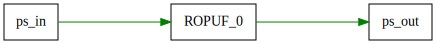

In [4]:
switch_PUF(0)
PUF.graph

In [5]:
input_buffer[:] = [int("0000", base = 16)] #126075
for j in range(math.floor(buffer_size/2)):
    index_l = j*2;
    index_r = index_l + 2;
    dma_send.transfer(input_buffer)
    dma_send.wait()
    dma_recv.transfer(output_buffer[index_l:index_r])
    dma_recv.wait()
print(output_buffer[::2]) #even index
print(output_buffer[1::2]) #odd index

[4138]
[4138]


  0%|          | 0/4 [00:00<?, ?it/s]

0


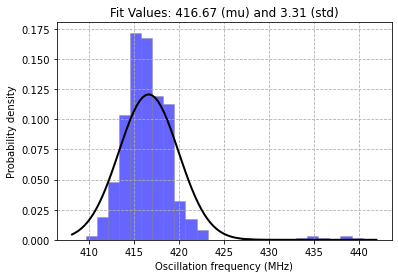

0


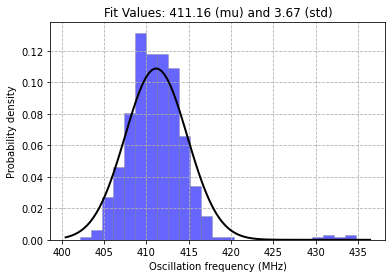

0


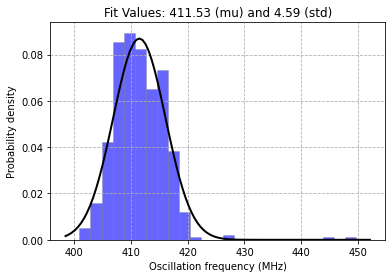

0


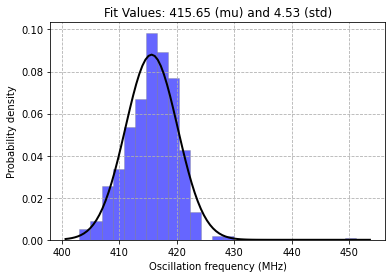

In [6]:
# pdf of the oscillation frequency 
debug = [0 for x in range(1000)]
freq_out = np.zeros(shape=(n_PUF,n_ROs))
for j in tqdm(range(n_PUF)):
    counter = 0
    switch_PUF(j)
    frequency = np.zeros(shape=(2,n_ROs)) #data1[y][x] 
    challenge = 0
    for i in range(n_ROs):
        input_buffer[:] = challenge
        challenge = challenge + n_ROs + 1;
        for k in range(math.floor(buffer_size/2)):
            index_l = k*2;
            index_r = index_l + 2;
            dma_send.transfer(input_buffer)
            dma_send.wait()
            dma_recv.transfer(output_buffer[index_l:index_r])
            dma_recv.wait()
        frequency[0][i] = np.float32(output_buffer[::2])/wait_ns*clk_period_ns*100
        frequency[1][i] = np.float32(output_buffer[1::2])/wait_ns*clk_period_ns*100
        if(frequency[0][i] < 100):
            debug[counter] = challenge - n_ROs - 1
            counter += 1
    freq_out[j,:] = frequency[0,:]
    print(counter)
    mu, std = norm.fit(frequency[0,:]) 
    plt.figure()
    plt.hist(frequency[0,:], bins=25, density=True, alpha=0.6, color='b',edgecolor='gray', linewidth=0.5)
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    title = "Fit Values: {:.2f} (mu) and {:.2f} (std)".format(mu, std)
    plt.title(title)
    plt.xlabel("Oscillation frequency (MHz)")
    plt.ylabel("Probability density")    
    plt.grid(linestyle = '--')
    plt.savefig(data_path + 'f' + str(j) + '.png',dpi=150)
    plt.show()

heading = ['f0','f1','f2','f3','f4','f5','f6','f7']
f = open(data_path + 'freq.csv','w')
wr = csv.writer(f)
wr.writerow(heading)
for x in range(n_ROs):
    wr.writerow(freq_out[:,x])
f.close()

In [7]:
# Returns a list of responses to all challenges of the 256 RO PUF 
def full_CR_space(PUF_index):
    switch_PUF(PUF_index)
    # Note: set buffer_size = 2
    # N*(N-1)/2 unique pairs => 
    n_unique_pairs = math.floor(n_ROs*(n_ROs-1)/2) # 0 -> N-1 pairs, 1 -> N-2 pairs etc. Sum of N-1 to 1 
    response = [0 for x in range(n_unique_pairs)]
    challenge = 0
    l = 0
    for i in tqdm(range(n_ROs-1)):
        challenge = challenge + (i+1);
        for k in range(n_ROs - (i+1)):
            input_buffer[:] = challenge
            challenge = challenge + 1;
            for j in range(math.floor(buffer_size/2)):
                index_l = j*2;
                index_r = index_l + 2;
                dma_send.transfer(input_buffer)
                dma_send.wait()
                dma_recv.transfer(output_buffer[index_l:index_r])
                dma_recv.wait()
            output = list(output_buffer)
            if (l%2 == 0):
                if (output[0] > output[1]):
                    response[l] = 1
                else:
                    response[l] = 0
            else:
                if (output[0] < output[1]):
                    response[l] = 1
                else:
                    response[l] = 0
            l = l +1
    return response

In [8]:
#Get all CR pairs of all devices
n_unique_pairs = math.floor(n_ROs*(n_ROs-1)/2)
response_matrix = [[0 for x in range(n_unique_pairs)] for y in range(n_PUF)] #[y][x]
for i in range(n_PUF):
    response_matrix[i][:] = full_CR_space(i)
    
heading = ['r0','r1','r2','r3','r4','r5','r6','r7']
f = open(data_path + 'CRP_space.csv','w')
wr = csv.writer(f)
wr.writerow(heading)
for x in range(n_unique_pairs):
    wr.writerow([i[x] for i in response_matrix])
f.close()

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

In [9]:
#Uniformity: ideal 0.5
uniformity = [0 for x in range(n_PUF)]
for i in range(n_PUF):
    uniformity[i] = sum(response_matrix[i][:])/len(response_matrix[i][:])
print(uniformity)

heading = ['u0','u1','u2','u3','u4','u5','u6','u7']
f = open(data_path + 'uniformity.csv','w')
wr = csv.writer(f)
wr.writerow(heading)
wr.writerow(uniformity)
f.close()

[0.49555100293542076, 0.49559686888454013, 0.4966212084148728, 0.49650654354207435]


In [10]:
#Uniqueness across all devices: ideal 0.5
uniqueness = 0
for i in range(n_PUF):
    for j in range((i+1),n_PUF):
        uniqueness = uniqueness + hamming(response_matrix[i][:],response_matrix[j][:])
uniqueness = 2/(n_PUF*(n_PUF-1))*uniqueness
print(uniqueness)

heading = ['uniqueness_all']
f = open(data_path + 'uniqueness_all.csv','w')
wr = csv.writer(f)
wr.writerow(heading)
wr.writerow([uniqueness])
f.close()

0.4810153192270058


In [11]:
#Uniqueness of individual PUFs: ideal 0.5
uniqueness_matrix = [0 for x in range(n_PUF)]

for i in range(n_PUF):
    uniqueness_single_device = 0
    for j in range(n_PUF):
        if i != j:
            uniqueness_single_device = uniqueness_single_device + hamming(response_matrix[i][:],response_matrix[j][:])
    uniqueness_matrix[i] = 1/(n_PUF-1)*uniqueness_single_device
print(uniqueness_matrix)

heading = ['u0','u1','u2','u3','u4','u5','u6','u7']
f = open(data_path + 'uniqueness_indiv.csv','w')
wr = csv.writer(f)
wr.writerow(heading)
wr.writerow(uniqueness_matrix)
f.close()

[0.5493339244944553, 0.4781907411937377, 0.4358411815068493, 0.4606954297129811]


In [12]:
def find_indices(list_to_check, item_to_find):
    indices = []
    for idx, value in enumerate(list_to_check):
        if value == item_to_find:
            indices.append(idx)
    return indices

n_bits = int(n_ROs*(n_ROs-1)/2)
format_str = '{0:0' + str(n_bits) + 'b}'

#Reliability of all devices: ideal 1.0
reliability_matrix = [0 for x in range(n_PUF)] #[y][x]
unstable_bits_count = [0 for x in range(n_PUF)]
n_of_runs = 5
for i in range(n_PUF):
    response_matrix_single_device = [[0 for x in range(n_bits)] for y in range(n_of_runs)] #[y][x]
    for j in range(n_of_runs):
        response_matrix_single_device[j][:] = full_CR_space(i)
        
    temp1 = int("".join(str(x) for x in response_matrix_single_device[0][:]), 2)
    temp2 = int("".join(str(x) for x in response_matrix_single_device[1][:]), 2)
    temp3 = [int(x) for x in list(format_str.format(temp1^temp2))]
    unstable_bits = find_indices(temp3,1)
    for k in range(2,n_of_runs):
        temp2 = int("".join(str(x) for x in response_matrix_single_device[k][:]), 2)
        temp3 = [int(x) for x in list(format_str.format(temp1^temp2))]
        temp3 = find_indices(temp3,1)
        for l in range(len(temp3)):
            unstable_bits.append(temp3[l]) if temp3[l] not in unstable_bits else unstable_bits

    unstable_bits_count[i] = len(unstable_bits)
        
    n_HD = math.floor(n_of_runs*(n_of_runs-1)/2)
    HD = [0 for x in range(n_HD)]
    l = 0
    for x in range(n_of_runs-1):
        for y in range(x+1, n_of_runs):
            HD[l] = 1 - hamming(response_matrix_single_device[x][:],response_matrix_single_device[y][:])
            l = l + 1
    reliability_matrix[i] = sum(HD)/n_HD

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

  0%|          | 0/511 [00:00<?, ?it/s]

In [13]:
print(reliability_matrix)

heading = ['r0','r1','r2','r3','r4','r5','r6','r7']
f = open(data_path + 'reliability.csv','w')
wr = csv.writer(f)
wr.writerow(heading)
wr.writerow(reliability_matrix)
f.close()

heading = ['u0','u1','u2','u3','u4','u5','u6','u7']
f = open(data_path + 'unstable_bits.csv','w')
wr = csv.writer(f)
wr.writerow(heading)
wr.writerow(unstable_bits_count)
f.close()

[0.9826565557729943, 0.9871881115459884, 0.9906922700587085, 0.9882751345401175]


In [14]:
output_buffer.freebuffer()
input_buffer.freebuffer()